In [1]:
!pwd

/tf/aiffel/aiffel_quest/GoingDeeper(CV)_RS7_07


In [2]:
ls wider_face_split  WIDER_test  WIDER_train  WIDER_val

ls: cannot access 'wider_face_split': No such file or directory
ls: cannot access 'WIDER_test': No such file or directory
ls: cannot access 'WIDER_train': No such file or directory
ls: cannot access 'WIDER_val': No such file or directory


In [3]:
!head -20 widerface/wider_face_split/wider_face_train_bbx_gt.txt

0--Parade/0_Parade_marchingband_1_849.jpg
1
449 330 122 149 0 0 0 0 0 0 
0--Parade/0_Parade_Parade_0_904.jpg
1
361 98 263 339 0 0 0 0 0 0 
0--Parade/0_Parade_marchingband_1_799.jpg
21
78 221 7 8 2 0 0 0 0 0 
78 238 14 17 2 0 0 0 0 0 
113 212 11 15 2 0 0 0 0 0 
134 260 15 15 2 0 0 0 0 0 
163 250 14 17 2 0 0 0 0 0 
201 218 10 12 2 0 0 0 0 0 
182 266 15 17 2 0 0 0 0 0 
245 279 18 15 2 0 0 0 0 0 
304 265 16 17 2 0 0 0 2 1 
328 295 16 20 2 0 0 0 0 0 
389 281 17 19 2 0 0 0 2 0 
406 293 21 21 2 0 1 0 0 0 


In [166]:
import os, cv2, time
import tensorflow as tf
tf.random.set_seed(1000)

import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt

PROJECT_PATH = '/tf/aiffel/aiffel_quest/GoingDeeper(CV)_RS7_07'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')

DATASET_LEN = 12880
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

print(tf.__version__)

2.15.0


In [167]:
def parse_box(data):
    x0 = int(data[0])
    y0 = int(data[1])
    w = int(data[2])
    h = int(data[3])
    return x0, y0, w, h

print('슝=3')

슝=3


In [168]:
def parse_widerface(file):
    infos = []
    with open(file) as fp:
        line = fp.readline()
        while line:
            n_object = int(fp.readline())
            boxes = []
            for i in range(n_object):
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                if (w == 0) or (h == 0):
                    continue
                boxes.append([x0, y0, w, h])
            if n_object == 0:
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                boxes.append([x0, y0, w, h])
            infos.append((line.strip(), boxes))
            line = fp.readline()
    return infos

print('슝=3')

슝=3


In [169]:
def process_image(image_file):
    image_string = tf.io.read_file(image_file)
    try:
        image_data = tf.image.decode_jpeg(image_string, channels=3)
        return 0, image_string, image_data
    except tf.errors.InvalidArgumentError:
        return 1, image_string, None

print('슝=3')

슝=3


In [170]:
def xywh_to_voc(file_name, boxes, image_data):
    shape = image_data.shape
    image_info = {}
    image_info['filename'] = file_name
    image_info['width'] = shape[1]
    image_info['height'] = shape[0]
    image_info['depth'] = 3

    difficult = []
    classes = []
    xmin, ymin, xmax, ymax = [], [], [], []

    for box in boxes:
        classes.append(1)
        difficult.append(0)
        xmin.append(box[0])
        ymin.append(box[1])
        xmax.append(box[0] + box[2])
        ymax.append(box[1] + box[3])
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    image_info['difficult'] = difficult

    return image_info

print('슝=3')

슝=3


In [171]:
def make_example(image_string, image_infos):
    for info in image_infos:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']

    if isinstance(image_string, type(tf.constant(0))):
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]

    base_name = [tf.compat.as_bytes(os.path.basename(filename))]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    
    return example

print('슝=3')

슝=3


# tfrecord 생성

In [172]:
if not (os.path.exists(path=TRAIN_TFRECORD_PATH) and os.path.exists(path=VALID_TFRECORD_PATH)):
    for split in ['train', 'val']:
        if split == 'train':
            output_file = TRAIN_TFRECORD_PATH 
            anno_txt = 'wider_face_train_bbx_gt.txt'
            file_path = 'WIDER_train'
        else:
            output_file = VALID_TFRECORD_PATH
            anno_txt = 'wider_face_val_bbx_gt.txt'
            file_path = 'WIDER_val'

        with tf.io.TFRecordWriter(output_file) as writer:
            for info in tqdm.tqdm(parse_widerface(os.path.join(DATA_PATH, 'wider_face_split', anno_txt))):
                image_file = os.path.join(DATA_PATH, file_path, 'images', info[0])
                error, image_string, image_data = process_image(image_file)
                boxes = xywh_to_voc(image_file, info[1], image_data)

                if not error:
                    tf_example = make_example(image_string, [boxes])
                    writer.write(tf_example.SerializeToString())

In [173]:
BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
BOX_STEPS = [8, 16, 32, 64]

print('슝=3')

슝=3


In [174]:
image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
min_sizes = BOX_MIN_SIZES
steps= BOX_STEPS

feature_maps = [
    [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
    for step in steps
]
feature_maps

[[32, 40], [16, 20], [8, 10], [4, 5]]

In [175]:
boxes = []
for k, f in enumerate(feature_maps):
    for i, j in product(range(f[0]), range(f[1])):
        for min_size in min_sizes[k]:
            s_kx = min_size / image_sizes[1]
            s_ky = min_size / image_sizes[0]
            cx = (j + 0.5) * steps[k] / image_sizes[1]
            cy = (i + 0.5) * steps[k] / image_sizes[0]
            boxes += [cx, cy, s_kx, s_ky]
len(boxes)

18800

In [176]:
pretty_boxes = np.asarray(boxes).reshape([-1, 4])
print(pretty_boxes.shape)
print(pretty_boxes)

(4700, 4)
[[0.0125    0.015625  0.03125   0.0390625]
 [0.0125    0.015625  0.05      0.0625   ]
 [0.0125    0.015625  0.075     0.09375  ]
 ...
 [0.9       0.875     0.4       0.5      ]
 [0.9       0.875     0.6       0.75     ]
 [0.9       0.875     0.8       1.       ]]


In [177]:
def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

print('슝=3')

슝=3


In [178]:
def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    block_id = (tf.keras.backend.get_uid())
    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    
    x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)

print('슝=3')

슝=3


In [179]:
def _depthwise_conv_block(inputs, filters, strides=(1, 1)):
    block_id = tf.keras.backend.get_uid()
    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        strides=strides,
                                        use_bias=False,
                                        name='conv_dw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                               padding='same',
                               use_bias=False,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)

print('슝=3')

슝=3


In [180]:
def _branch_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])
    return tf.keras.layers.ReLU()(x)

print('슝=3')

슝=3


In [181]:
def _create_head_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    return x

print('슝=3')

슝=3


In [182]:
def _compute_heads(inputs, num_class, num_cell):
    conf = _create_head_block(inputs, num_cell * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs, num_cell * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)
    return conf, loc

print('슝=3')

슝=3


In [183]:
def SsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

print('슝=3')

슝=3


In [184]:
model = SsdModel()
print("the number of model layers: ", len(model.layers))
model.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 320, 3)]        0         []                            
                                                                                                  
 conv_pad_85 (ZeroPadding2D  (None, 258, 322, 3)          0         ['input_image[0][0]']         
 )                                                                                                
                                                                                                  
 conv_85 (Conv2D)            (None, 128, 160, 16)         432       ['conv_pad_85[0][0]']         
                                                                                                  
 conv_bn_85 (BatchNormaliza  (None, 128, 160, 16)        

# augmentation 생성

In [185]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)

        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels

print('슝=3')

슝=3


In [186]:
def _resize(img, labels):
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            #　size h,w
            return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

print('슝=3')

슝=3


In [187]:
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels

print('슝=3')

슝=3


In [188]:
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)
    return img

print('슝=3')

슝=3


In [189]:
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

print('슝=3')

슝=3


In [190]:
def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]

print('슝=3')

슝=3


In [191]:
def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

print('슝=3')

슝=3


In [192]:
def _encode_bbox(matched, boxes, variances=[0.1, 0.2]):
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - boxes[:, :2]
    g_cxcy /= (variances[0] * boxes[:, 2:])
    g_wh = (matched[:, 2:] - matched[:, :2]) / boxes[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    g_wh = tf.where(tf.math.is_inf(g_wh), 0.0, g_wh)
    return tf.concat([g_cxcy, g_wh], 1)

print('슝=3')

슝=3


In [193]:
def encode_tf(labels, boxes):
    match_threshold = 0.45
    boxes = tf.cast(boxes, tf.float32)
    bbox = labels[:, :4]
    conf = labels[:, -1]
   
    # jaccard index
    overlaps = _jaccard(bbox, boxes)
    best_box_overlap = tf.reduce_max(overlaps, 1)
    best_box_idx = tf.argmax(overlaps, 1, tf.int32)

    best_truth_overlap = tf.reduce_max(overlaps, 0)
    best_truth_idx = tf.argmax(overlaps, 0, tf.int32)

    best_truth_overlap = tf.tensor_scatter_nd_update(
        best_truth_overlap, tf.expand_dims(best_box_idx, 1),
        tf.ones_like(best_box_idx, tf.float32) * 2.)
    best_truth_idx = tf.tensor_scatter_nd_update(
        best_truth_idx, tf.expand_dims(best_box_idx, 1),
        tf.range(tf.size(best_box_idx), dtype=tf.int32))
    # Scale Ground-Truth Boxes   
    matches_bbox = tf.gather(bbox, best_truth_idx)
    loc_t = _encode_bbox(matches_bbox, boxes)
    conf_t = tf.gather(conf, best_truth_idx)
    conf_t = tf.where(tf.less(best_truth_overlap, match_threshold), tf.zeros_like(conf_t), conf_t)

    return tf.concat([loc_t, conf_t[..., tf.newaxis]], axis=1)

print('슝=3')

슝=3


In [194]:
def _transform_data(train, boxes):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if train:
            img, labels = _crop(img, labels)
            img = _pad_to_square(img)

        img, labels = _resize(img, labels)

        if train:
            img, labels = _flip(img, labels)

        if train:
            img = _distort(img)
        labels = encode_tf(labels, boxes)        
        img = img/255.0
        return img, labels
    return transform_data

print('슝=3')

슝=3


In [195]:
def _parse_tfrecord(train, boxes):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(train, boxes)(img, labels)

        return img, labels
    return parse_tfrecord

print('슝=3')

슝=3


In [196]:
def load_tfrecord_dataset(tfrecord_name, train=True, boxes=None, buffer_size=1024):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.cache()
    if train:
        raw_dataset = raw_dataset.repeat()
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)

    dataset = raw_dataset.map(_parse_tfrecord(train, boxes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

print('슝=3')

슝=3


In [197]:
def load_dataset(boxes, train=True, buffer_size=1024):
    if train:
        dataset = load_tfrecord_dataset(
            tfrecord_name=TRAIN_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    else:
        dataset = load_tfrecord_dataset(
            tfrecord_name=VALID_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    return dataset

print('슝=3')

슝=3


In [198]:
class PiecewiseConstantWarmUpDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, boundaries, values, warmup_steps, min_lr, name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda: tf.constant(v)))

            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

print('슝=3')

슝=3


In [199]:
def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)

print('슝=3')

슝=3


In [200]:
def hard_negative_mining(loss, class_truth, neg_ratio):
    pos_idx = class_truth > 0
    num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx

print('슝=3')

슝=3


In [201]:
def MultiBoxLoss(num_class, neg_pos_ratio=3.0):
    def multi_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        temp_loss = cross_entropy(class_truth, class_pred)
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
        loss_class = cross_entropy(
            class_truth[tf.math.logical_or(pos_idx, neg_idx)],
            class_pred[tf.math.logical_or(pos_idx, neg_idx)])
        
        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.float32))

        loss_class = loss_class / num_pos
        loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return multi_loss

print('슝=3')

슝=3


In [202]:
boxes = default_box()
train_dataset = load_dataset(boxes, train=True)

print('슝=3')

슝=3


Model: "ssd_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 320, 3)]        0         []                            
                                                                                                  
 conv_pad_99 (ZeroPadding2D  (None, 258, 322, 3)          0         ['input_image[0][0]']         
 )                                                                                                
                                                                                                  
 conv_99 (Conv2D)            (None, 128, 160, 16)         432       ['conv_pad_99[0][0]']         
                                                                                                  
 conv_bn_99 (BatchNormaliza  (None, 128, 160, 16)         64        ['conv_99[0][0]']     

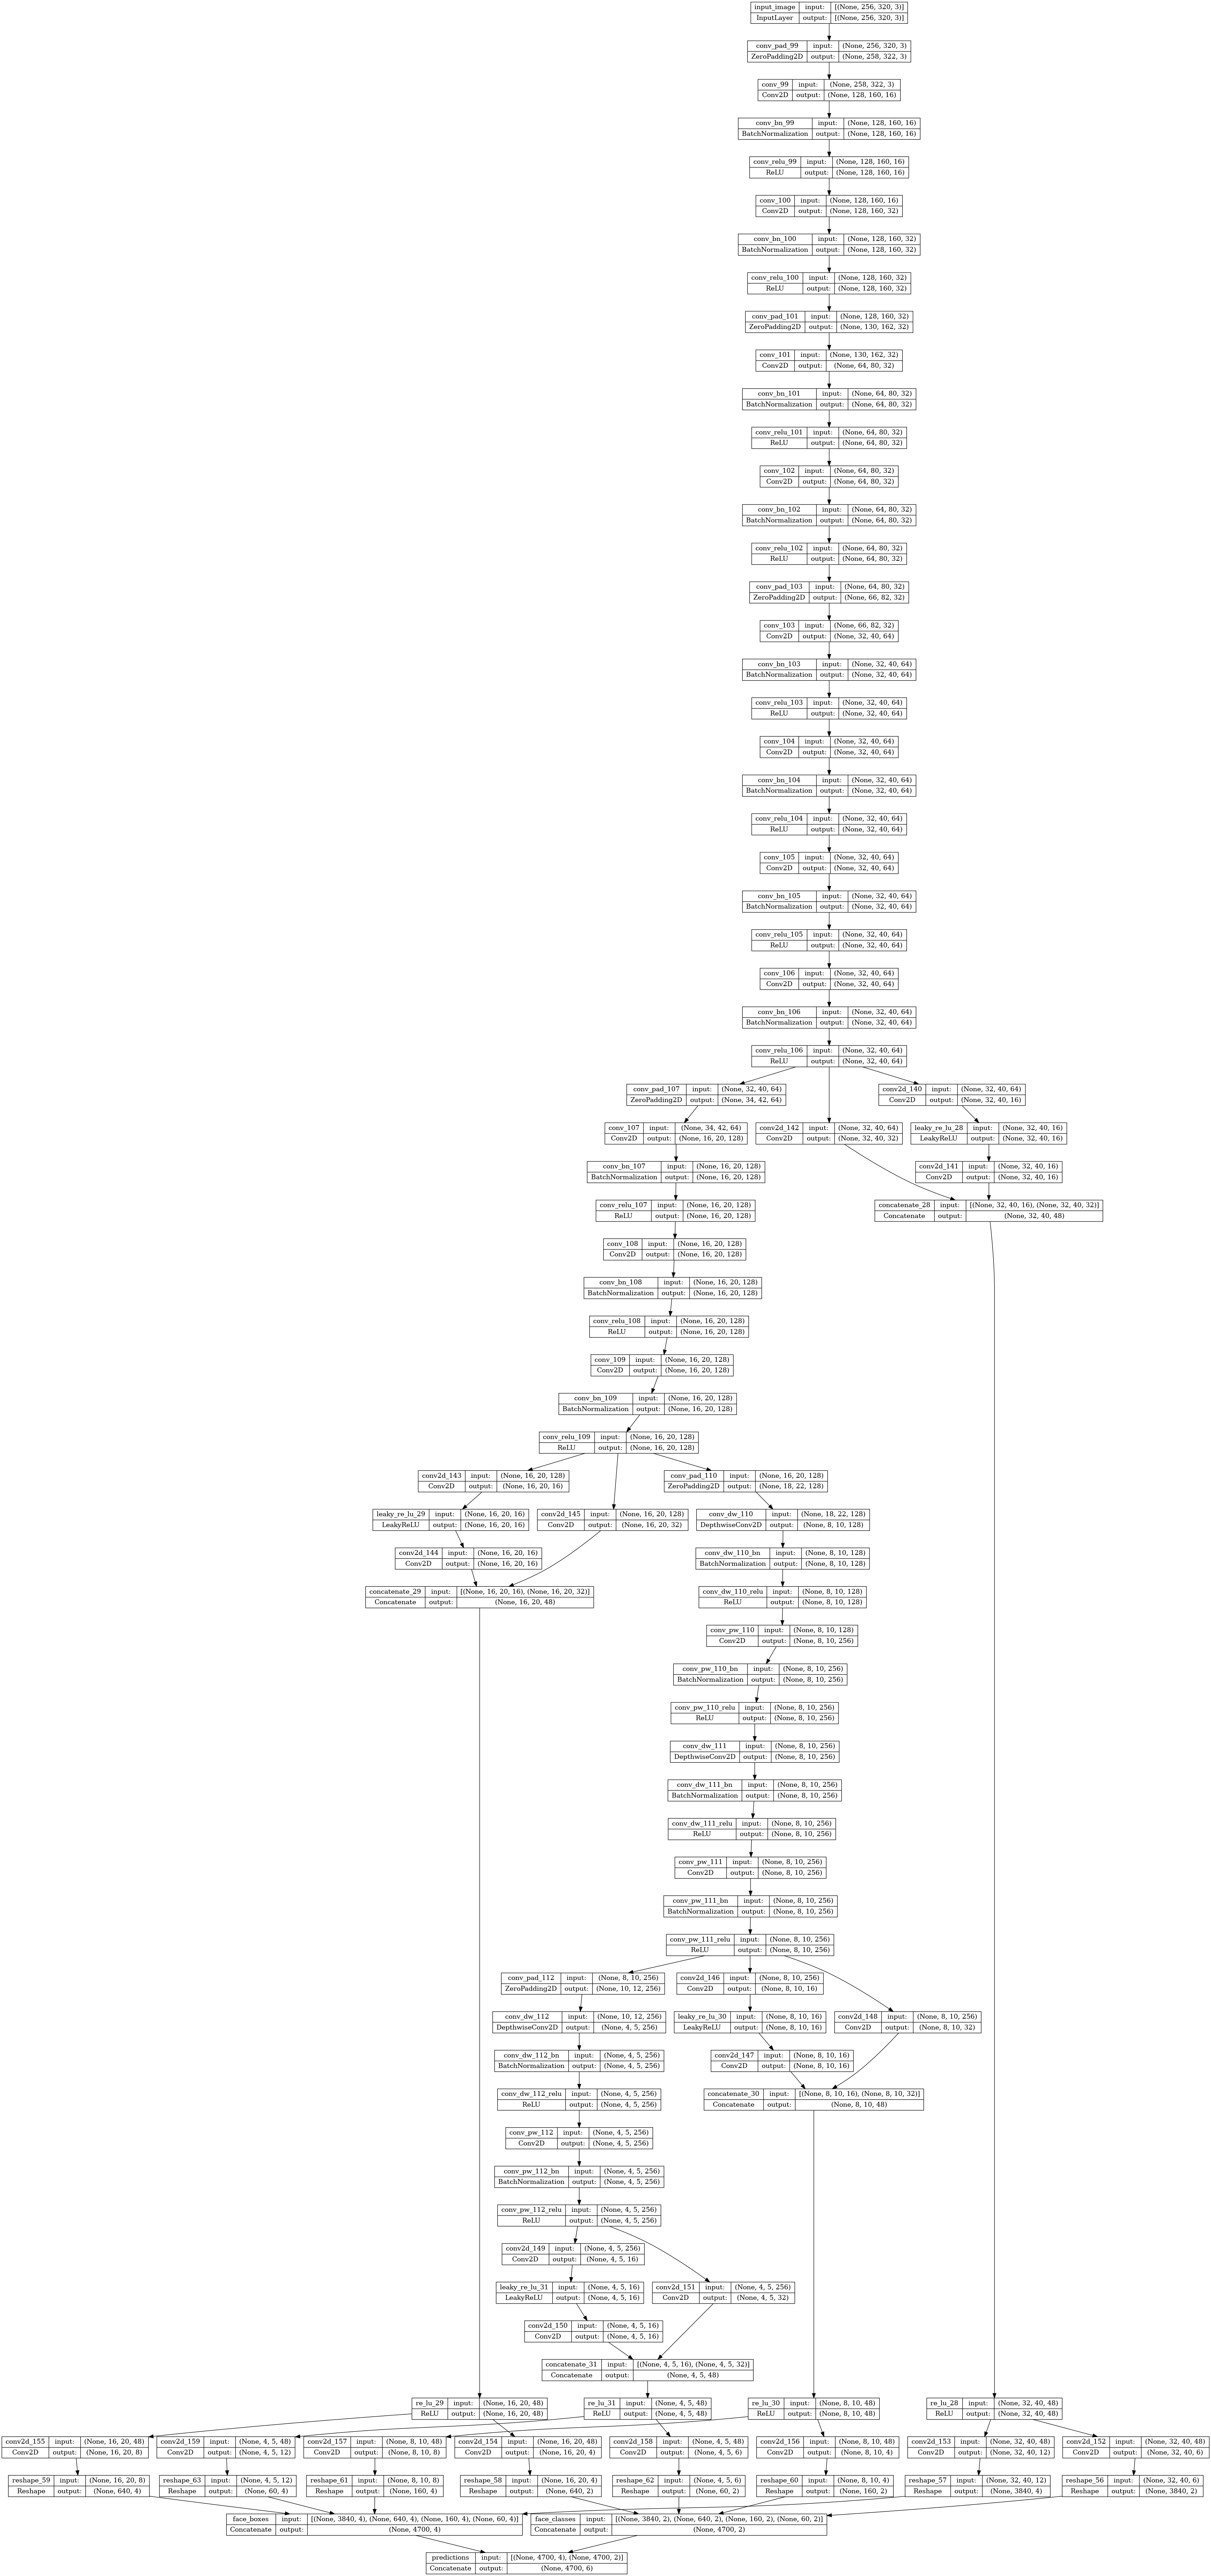

In [203]:
model = SsdModel()
model.summary()
tf.keras.utils.plot_model(
    model, 
    to_file=os.path.join(os.getcwd(), 'model.png'),
    show_shapes=True, 
    show_layer_names=True
)

In [204]:
steps_per_epoch = DATASET_LEN // BATCH_SIZE
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=1e-2,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.1,
    warmup_steps=5*steps_per_epoch,
    min_lr=1e-4
)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

print('슝=3')

슝=3


In [205]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

print('슝=3')

슝=3


In [206]:
EPOCHS = 20
import time

import time

def train_model(EPOCHS, train_dataset, steps_per_epoch, train_step):
    history = {
        'loss': [],
        'loc_loss': [],
        'class_loss': []
    }

    start_training_time = time.time()  # Start time for total training

    for epoch in range(EPOCHS):
        start_epoch_time = time.time()  # Start time for this epoch

        epoch_loss = 0
        epoch_loc_loss = 0
        epoch_class_loss = 0

        for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
            load_t0 = time.time()
            total_loss, losses = train_step(inputs, labels)
            load_t1 = time.time()
            batch_time = load_t1 - load_t0

            # Accumulate epoch losses
            epoch_loss += total_loss
            epoch_loc_loss += losses['loc']
            epoch_class_loss += losses['class']

            print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ", end='', flush=True)

        end_epoch_time = time.time()  # End time for this epoch
        epoch_duration = end_epoch_time - start_epoch_time
        print(f"\nEpoch {epoch + 1}/{EPOCHS} completed in {epoch_duration:.2f} seconds")

        # Record the average loss at the end of each epoch
        history['loss'].append(epoch_loss / steps_per_epoch)
        history['loc_loss'].append(epoch_loc_loss / steps_per_epoch)
        history['class_loss'].append(epoch_class_loss / steps_per_epoch)

    end_training_time = time.time()  # End time for total training
    total_training_duration = end_training_time - start_training_time
    print(f"Total training completed in {total_training_duration:.2f} seconds")

    return history


In [207]:

history20 = train_model(20, train_dataset, steps_per_epoch, train_step)


Epoch: 1/20 | Batch 402/402 | Batch time 0.023 || Loss: 8.357119 | loc loss:5.286331 | class loss:3.070788   
Epoch 1/20 completed in 33.09 seconds
Epoch: 2/20 | Batch 402/402 | Batch time 0.023 || Loss: 6.676197 | loc loss:4.796950 | class loss:1.879247  
Epoch 2/20 completed in 28.34 seconds
Epoch: 3/20 | Batch 402/402 | Batch time 0.023 || Loss: 7.158211 | loc loss:5.061394 | class loss:2.096817  
Epoch 3/20 completed in 27.84 seconds
Epoch: 4/20 | Batch 402/402 | Batch time 0.015 || Loss: 5.740316 | loc loss:3.854022 | class loss:1.886294  
Epoch 4/20 completed in 27.50 seconds
Epoch: 5/20 | Batch 402/402 | Batch time 0.023 || Loss: 6.015575 | loc loss:4.255271 | class loss:1.760304  
Epoch 5/20 completed in 26.60 seconds
Epoch: 6/20 | Batch 402/402 | Batch time 0.019 || Loss: 5.394652 | loc loss:3.799174 | class loss:1.595478  
Epoch 6/20 completed in 26.36 seconds
Epoch: 7/20 | Batch 402/402 | Batch time 0.015 || Loss: 8.019945 | loc loss:6.223583 | class loss:1.796363 2 
Epoch 7

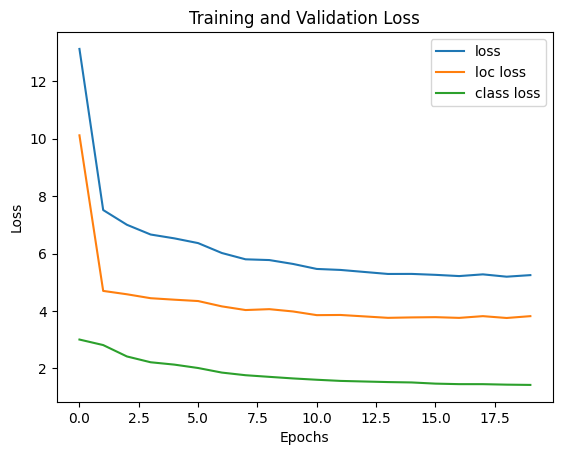

In [217]:
import matplotlib.pyplot as plt

def plot_training_and_validation_loss(history):
    plt.figure()
    plt.plot(history['loss'], label='loss')
    plt.plot(history['loc_loss'], label='loc loss')
    plt.plot(history['class_loss'], label='class loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 이 함수를 사용하려면, 다음과 같이 history 객체를 전달합니다.
# 예를 들어: plot_training_and_validation_loss(history20)
plot_training_and_validation_loss(history20)

In [210]:
def compute_nms(boxes, scores, nms_threshold=0.4, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou
        )

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

print('슝=3')

슝=3


In [211]:
def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

print('슝=3')

슝=3


In [212]:
def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.5

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

print('슝=3')

슝=3


In [213]:
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

print('슝=3')

슝=3


In [214]:
def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes

print('슝=3')

슝=3


In [215]:
def draw_box_on_face(img, boxes, classes, scores, box_index, class_list):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

print('슝=3')

슝=3


# prior box 생성 

1/1 [==============================] - 0s 18ms/step


[[0.55933213 0.22801974 0.80407095 0.5548657 ]
 [0.35386252 0.22934756 0.57697934 0.5155587 ]
 [0.7053026  0.26282507 0.9517813  0.59443   ]]


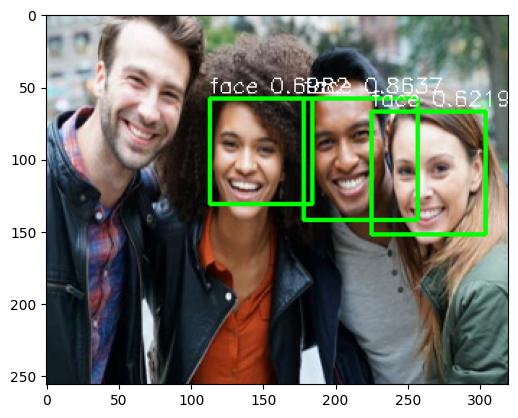

In [218]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

def predict_and_draw_boxes(image_path, model, image_width, image_height, box_steps, image_labels, pad_input_image, default_box, parse_predict, recover_pad, draw_box_on_face, project_path):
    # Load and preprocess the image
    img_raw = cv2.imread(image_path)
    img_raw = cv2.resize(img_raw, (image_width, image_height))
    img = np.float32(img_raw.copy())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, pad_params = pad_input_image(img, max_steps=max(box_steps))
    img = img / 255.0

    # Generate and process predictions
    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)
    predictions = model.predict(img[np.newaxis, ...])
    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    pred_boxes = recover_pad(pred_boxes, pad_params)
    print(pred_boxes)
    # Draw boxes on the image
    for box_index in range(len(pred_boxes)):
        draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, image_labels)
    
    # Display the image
    plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    plt.show()

# Example usage
TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image_people.png')
predict_and_draw_boxes(TEST_IMAGE_PATH, model, IMAGE_WIDTH, IMAGE_HEIGHT, BOX_STEPS, IMAGE_LABELS, pad_input_image, default_box, parse_predict, recover_pad, draw_box_on_face, PROJECT_PATH)


In [219]:
model.save("20epoch.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [220]:

history40 = train_model(10, train_dataset, steps_per_epoch, train_step)


Epoch: 1/10 | Batch 402/402 | Batch time 0.026 || Loss: 6.232991 | loc loss:4.872668 | class loss:1.360323 
Epoch 1/10 completed in 30.83 seconds
Epoch: 2/10 | Batch 402/402 | Batch time 0.023 || Loss: 5.903212 | loc loss:4.591191 | class loss:1.312021  
Epoch 2/10 completed in 30.04 seconds
Epoch: 3/10 | Batch 402/402 | Batch time 0.027 || Loss: 4.339593 | loc loss:3.051328 | class loss:1.288265 
Epoch 3/10 completed in 30.69 seconds
Epoch: 4/10 | Batch 402/402 | Batch time 0.013 || Loss: 4.767919 | loc loss:3.509699 | class loss:1.258220 
Epoch 4/10 completed in 30.99 seconds
Epoch: 5/10 | Batch 402/402 | Batch time 0.029 || Loss: 4.843231 | loc loss:3.429102 | class loss:1.414128 
Epoch 5/10 completed in 31.29 seconds
Epoch: 6/10 | Batch 402/402 | Batch time 0.024 || Loss: 4.388424 | loc loss:3.289011 | class loss:1.099413 
Epoch 6/10 completed in 32.04 seconds
Epoch: 7/10 | Batch 402/402 | Batch time 0.018 || Loss: 4.263187 | loc loss:3.251462 | class loss:1.011725 
Epoch 7/10 comp

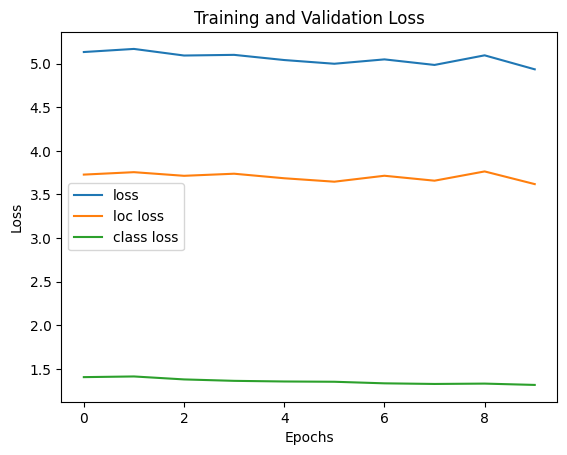

In [221]:
plot_training_and_validation_loss(history40)

In [222]:
model.save("30epoch.h5")

# multiface detection

1/1 [==============================] - 0s 22ms/step


[[0.11410724 0.06455551 0.3229394  0.3759908 ]
 [0.32387802 0.19175833 0.5188563  0.4435603 ]
 [0.5665761  0.19432998 0.7585759  0.44557106]
 [0.6943842  0.27358103 0.9045888  0.5471543 ]]


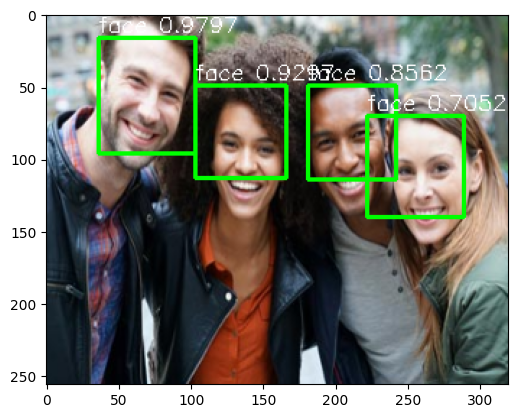

In [223]:
predict_and_draw_boxes(TEST_IMAGE_PATH, model, IMAGE_WIDTH, IMAGE_HEIGHT, BOX_STEPS, IMAGE_LABELS, pad_input_image, default_box, parse_predict, recover_pad, draw_box_on_face, PROJECT_PATH)


In [225]:
model.save("30epoch.h5")

In [224]:
%pip install opencv-python dlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 10.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.2-cp311-cp311-linux_x86_64.whl size=4351621 sha256=df81410f928b8b75eb10f8759cb57e1a21d3b34f5d3f5240eee8f773b79135fc
  Stored in directory: /root/.cache/pip/wheels/61/05/62/44b0bf18a0f8f9a0d65337b11237ecf12926d0d6e3807500bb
Successfully built dlib

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [231]:
def put_stickers(img, boxes, prior_index, img_sticker):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[prior_index][0] * img_width)
    y_min = int(boxes[prior_index][1] * img_height)
    x_max = int(boxes[prior_index][2] * img_width)
    y_max = int(boxes[prior_index][3] * img_height)
    
    w = x_max - x_min
    h = w//4
    if w > 0 and h > 0:
        img_sticker = cv2.resize(img_sticker, (w, h*2))
        # rest of your code
    else:
        print(f"Invalid dimensions for resizing: width={w}, height={h * 2}")
    
    
    # 흰색 배경을 위한 색상 범위 정의 (BGR 형식)
    lower_white = np.array([255, 255, 255], dtype=np.uint8)
    upper_white = np.array([255, 255, 255], dtype=np.uint8)

    # 흰색 배경 마스크 생성
    mask = cv2.inRange(img_sticker, lower_white, upper_white)
    mask_inv = cv2.bitwise_not(mask)

    # 스티커에서 배경 제거
    img_sticker_bg_removed = cv2.bitwise_and(img_sticker, img_sticker, mask=mask_inv)
    
    # 이미지에서 스티커에 대한 관심 영역(ROI) 계산
    sticker_area = img[y_min-h:y_min+h, x_min:x_min+w]
    
    # 스티커와 sticker_area가 같은 모양을 가지도록
    img_sticker_bg_removed = img_sticker_bg_removed[:sticker_area.shape[0], :sticker_area.shape[1], :]
    
    # 마스크를 사용하여 이미지에 스티커를 적용합니다.
    img[y_min-h:y_min+h, x_min:x_min+w] = np.where(img_sticker_bg_removed != 0, img_sticker_bg_removed, sticker_area).astype(np.uint8)

In [241]:
def predict_and_draw_boxes(image_path, model, image_width, image_height, box_steps, image_labels, pad_input_image, default_box, parse_predict, recover_pad, draw_box_on_face, project_path):
    # Load and preprocess the image
    img_raw = cv2.imread(image_path)
    img_raw = cv2.resize(img_raw, (image_width, image_height))
    img = np.float32(img_raw.copy())
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img, pad_params = pad_input_image(img, max_steps=max(box_steps))
    img = img / 255.0

    # Generate and process predictions
    boxes = default_box()
    boxes = tf.cast(boxes, tf.float32)
    predictions = model.predict(img[np.newaxis, ...])
    pred_boxes, labels, scores = parse_predict(predictions, boxes)
    pred_boxes = recover_pad(pred_boxes, pad_params)
    print(pred_boxes)
    # Draw boxes on the image
    for box_index in range(len(pred_boxes)):
        draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, image_labels)
    sticker_path = 'crown.png'
    img_raw = cv2.imread(TEST_IMAGE_PATH)
    img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
    if os.path.isfile(sticker_path):
        img_sticker = cv2.imread(sticker_path)
        plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
    else:
        print("스티커 사진이 없습니다")
    for prior_index in range(len(pred_boxes)):
        put_stickers(img_raw, pred_boxes, prior_index, img_sticker)
    # Display the image
    plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
    plt.show()


# 이미지 속 다수의 얼굴에 스티커 적용

1/1 [==============================] - 0s 17ms/step
[[0.11410724 0.06455551 0.3229394  0.3759908 ]
 [0.32387802 0.19175833 0.5188563  0.4435603 ]
 [0.5665761  0.19432998 0.7585759  0.44557106]
 [0.6943842  0.27358103 0.9045888  0.5471543 ]]


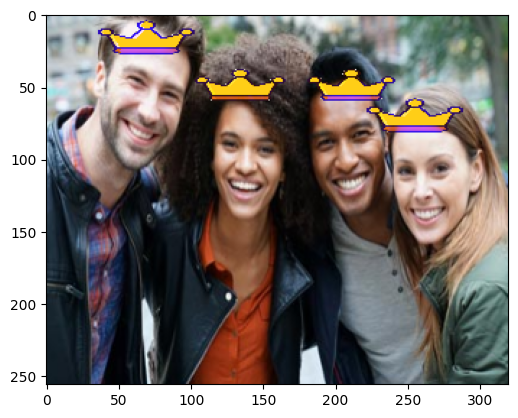

In [242]:
predict_and_draw_boxes(TEST_IMAGE_PATH, model, IMAGE_WIDTH, IMAGE_HEIGHT, BOX_STEPS, IMAGE_LABELS, pad_input_image, default_box, parse_predict, recover_pad, draw_box_on_face, PROJECT_PATH)


# 회고

 훈련에 대해 회고를 하자면 이번 훈련을 통해 재현율을 높이는 것이 중요하다는 생각을 했다. 여러번 20에폭을 돌렸는데 너무 다른 결과를 낸다는 사실을 알게 되었다. 그래서 랜덤시드를 고정시켜야 겠다는 생각을 했다. 물론 tensorflow 연산은 중 몇 부분은 비 결정론적일 수 있지만, 최대한 재현율을 높여야겠다고 생각했다. 그래서 이번 과정을 통해 가중치 초기화가 중요한 역할을 하는 것을 알게되었다. 랜덤 시드 1000으로 설정하니 20 에폭때 위치 로스가 상당히 적은 것을 확인했고 10에폭을 돌리니 클래스 로스가 1.0때가 되면서 4명을 온전히 인식하게 되었다. 그리고 그래프 상에서는 그 변화폭이 적은것 처럼 보이지만 로스 증감 폭이 어느 정도 있는것을 보고 해당 모델 체크포인트 콜백을 사용해서 save best checkpoint를 사용하는것이 무조건 바람직하다는 생각이 들었다.
 이번 과정에 대해 회고를 하자면 ,이번 과정은 오브젝트 디텍션이 였는데 이전 10장을 제대로 공부하지 못해 공부하는데 감을 잘 못잡았었다. 휴가를 쓰고 이전 오브젝트 디텍션 과정을 복습을 해봤는데 오브젝트 디텍션이 무엇인지 대략 감을 잡은 것 같다. 그리고 이번 프로젝트 augmentation 이후 과정은 코드 파악을 제대로 하지 못해 수행하 과제에 대해 아직 많이 파악을 못한 상태이다. 이후에 복습을 통해 더 파악을 할 예정이다.